# Data exploration

## Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import random
from shapely import geometry
import rasterio
from math import floor
import matplotlib.patches as patches

IMAGES_RGB_PATH = "data/AOI_3_Paris_Train/RGB-PanSharpen/"
COMMON_NAME_RGB = "RGB-PanSharpen_AOI_3_Paris_img"

GEOJSONS_PATH = "data/AOI_3_Paris_Train/geojson/buildings/"
COMMON_NAME_GEOJSONS = "buildings_AOI_3_Paris_img"

## Useful functions

In [16]:
def get_random_image():
    images_filenames = os.listdir(IMAGES_RGB_PATH)
    random_image_path = IMAGES_RGB_PATH + random.choice(images_filenames)
    index_image = random_image_path[len(IMAGES_RGB_PATH) + len(COMMON_NAME_RGB):-4]
    geojson_path = GEOJSONS_PATH + COMMON_NAME_GEOJSONS + index_image + ".geojson"
    return random_image_path, geojson_path
    

def gdal_to_rgb(ds):
    img = ds.ReadAsArray()
    img = np.transpose(img, (1, 2, 0))
    img = img.astype(np.float32)

    min_vals = np.min(img, axis=(0, 1))
    max_vals = np.max(img, axis=(0, 1))

    normalized_image = (img - min_vals) / (max_vals - min_vals)

    return (normalized_image * 255).astype(np.uint8)

def display_image(image_path):
    ds = gdal.Open(image_path)
    img = gdal_to_rgb(ds)
    plt.imshow(img)
    plt.axis('off')
    
    
def object_features(feature, ffa, aff):    
    poly = geometry.shape(feature['geometry'])
    center = poly.centroid
    x_center, y_center = ffa * (center.x, center.y)
    bbox = poly.bounds
    width = (bbox[2] - bbox[0]) // aff[0]
    height = (bbox[3] - bbox[1]) // -aff[4]
    out = ('obj_class', floor(x_center), floor(y_center), width, height)
    return out

## Dataset exploring

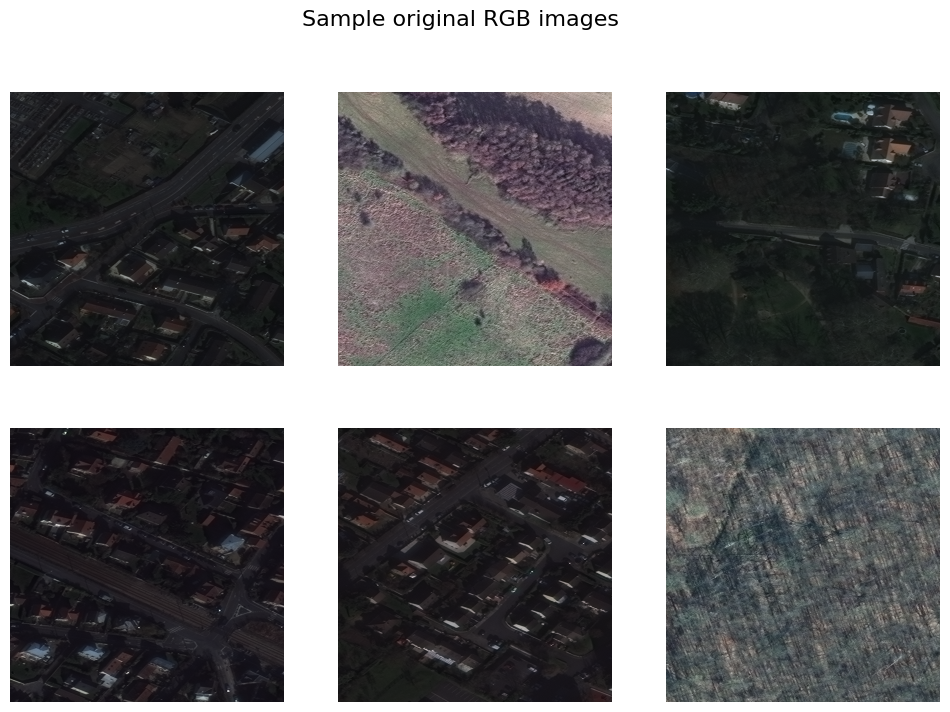

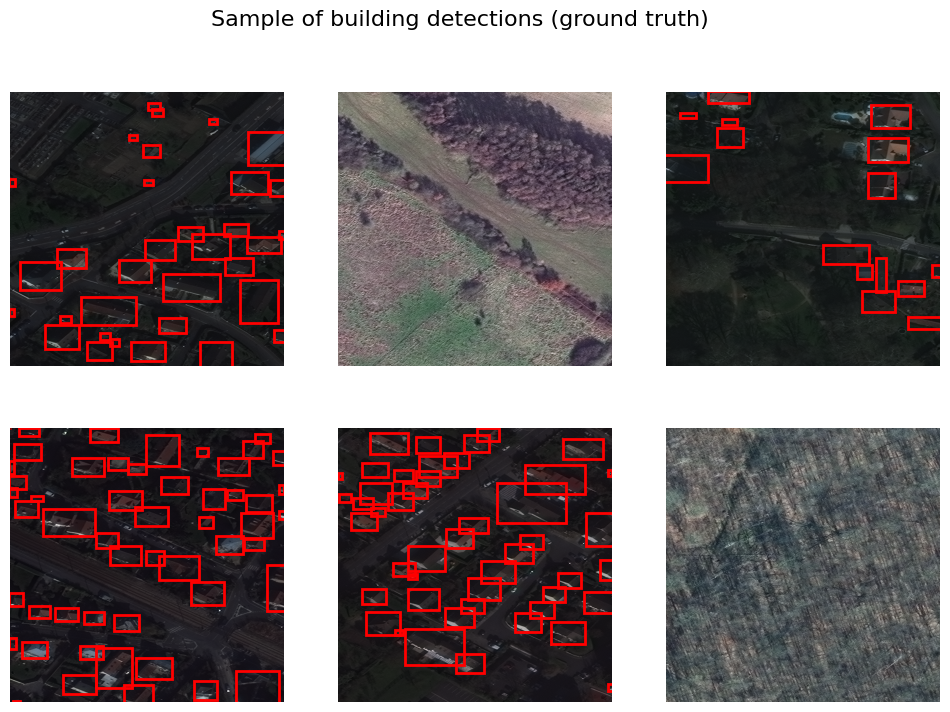

In [18]:
plt.figure(figsize=(12, 8))
grid_spec = plt.GridSpec(2, 3, width_ratios=[1, 1, 1])
images_random = [get_random_image() for i in range(6)]

plt.suptitle("Sample original RGB images", fontsize=16)
for i, (image_path, geo_file) in enumerate(images_random):
    plt.subplot(grid_spec[i])
    display_image(image_path)

plt.figure(figsize=(12, 8))
grid_spec = plt.GridSpec(2, 3, width_ratios=[1, 1, 1])

for i, (image_path, geo_file) in enumerate(images_random):
    ax = plt.subplot(grid_spec[i])
    
    with open(geo_file) as src:
        fc = json.load(src)

    with rasterio.open(image_path) as src:
        aff = src.transform
    
    ffa = ~aff
    
    bb_list = [object_features(feat, ffa, aff) for feat in fc['features']]

    ds = gdal.Open(image_path)
    img = gdal_to_rgb(ds)
    ax.imshow(img)
    ax.axis('off')
    
    for bb in bb_list:
        obj_class, x_center, y_center, width, height = bb
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
plt.suptitle("Sample of building detections (ground truth)", fontsize=16)
plt.show()